In [1]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt

In [3]:
latent_dim = 2 # Dimensionality of the latent space
input_shape = (28, 28, 1) # Input shape of MNIST images

# Encoder
encoder_inputs = keras.Input(shape=input_shape)
x = layers.Conv2D(32, 3, activation="relu", strides=2, padding="same")(encoder_inputs)
x = layers.Conv2D(64, 3, activation="relu", strides=2, padding="same")(x)
x = layers.Flatten()(x)
z_mean = layers.Dense(latent_dim, name="z_mean")(x)
z_log_var = layers.Dense(latent_dim, name="z_log_var")(x)

# Sampling function
# Sampling function
def sampling(args):
    z_mean, z_log_var = args
    batch = tf.shape(z_mean)[0]
    dim = tf.shape(z_mean)[1]
    epsilon = tf.keras.backend.random_normal(shape=(batch, dim))
    return z_mean + tf.exp(0.5 * z_log_var) * epsilon


z = layers.Lambda(sampling, output_shape=(latent_dim,), name='z')([z_mean, z_log_var])

encoder = keras.Model(encoder_inputs, [z_mean, z_log_var, z], name="encoder")

# Decoder
latent_inputs = keras.Input(shape=(latent_dim,))
x = layers.Dense(7 * 7 * 64, activation="relu")(latent_inputs)
x = layers.Reshape((7, 7, 64))(x)
x = layers.Conv2DTranspose(64, 3, activation="relu", strides=2, padding="same")(x)
x = layers.Conv2DTranspose(32, 3, activation="relu", strides=2, padding="same")(x)
decoder_outputs = layers.Conv2DTranspose(1, 3, activation="sigmoid", padding="same")(x)

decoder = keras.Model(latent_inputs, decoder_outputs, name="decoder")

# VAE model
outputs = decoder(encoder(encoder_inputs)[2])
vae = keras.Model(encoder_inputs, outputs, name="vae")


In [6]:
def vae_loss(x, x_decoded_mean, z_mean, z_log_var):
    reconstruction_loss = keras.losses.binary_crossentropy(x, x_decoded_mean)
    reconstruction_loss *= input_shape[0] * input_shape[1]
    kl_loss = 1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var)
    kl_loss = tf.reduce_mean(kl_loss)
    kl_loss *= -0.5
    return reconstruction_loss + kl_loss


vae.compile(optimizer=keras.optimizers.Adam(), loss=vae_loss)


In [7]:
# Load MNIST data
(x_train, _), (x_test, _) = keras.datasets.mnist.load_data()
x_train = x_train.astype("float32") / 255.0
x_test = x_test.astype("float32") / 255.0
x_train = np.reshape(x_train, (-1, 28, 28, 1))
x_test = np.reshape(x_test, (-1, 28, 28, 1))

# Train the VAE
vae.fit(x_train, x_train, epochs=10, batch_size=128, validation_data=(x_test, x_test))


Epoch 1/10


TypeError: in user code:

    File "C:\Users\Administrator\anaconda3\lib\site-packages\keras\engine\training.py", line 1284, in train_function  *
        return step_function(self, iterator)

    TypeError: outer_factory.<locals>.inner_factory.<locals>.tf__vae_loss() missing 2 required positional arguments: 'z_mean' and 'z_log_var'


Epoch 1/10
469/469 [==============================] - 67s 132ms/step - loss: 202.1850
Epoch 2/10
469/469 [==============================] - 64s 137ms/step - loss: 162.7608
Epoch 3/10
469/469 [==============================] - 58s 124ms/step - loss: 158.2121
Epoch 4/10
469/469 [==============================] - 59s 125ms/step - loss: 156.0732
Epoch 5/10
469/469 [==============================] - 59s 126ms/step - loss: 154.8033
Epoch 6/10
469/469 [==============================] - 60s 127ms/step - loss: 153.7294
Epoch 7/10
469/469 [==============================] - 66s 140ms/step - loss: 152.9015
Epoch 8/10
469/469 [==============================] - 64s 137ms/step - loss: 152.2258
Epoch 9/10
469/469 [==============================] - 62s 133ms/step - loss: 151.6314
Epoch 10/10
1/1 [==============================] - 0s 60ms/step


1/1 [==============================] - 0s 45ms/step


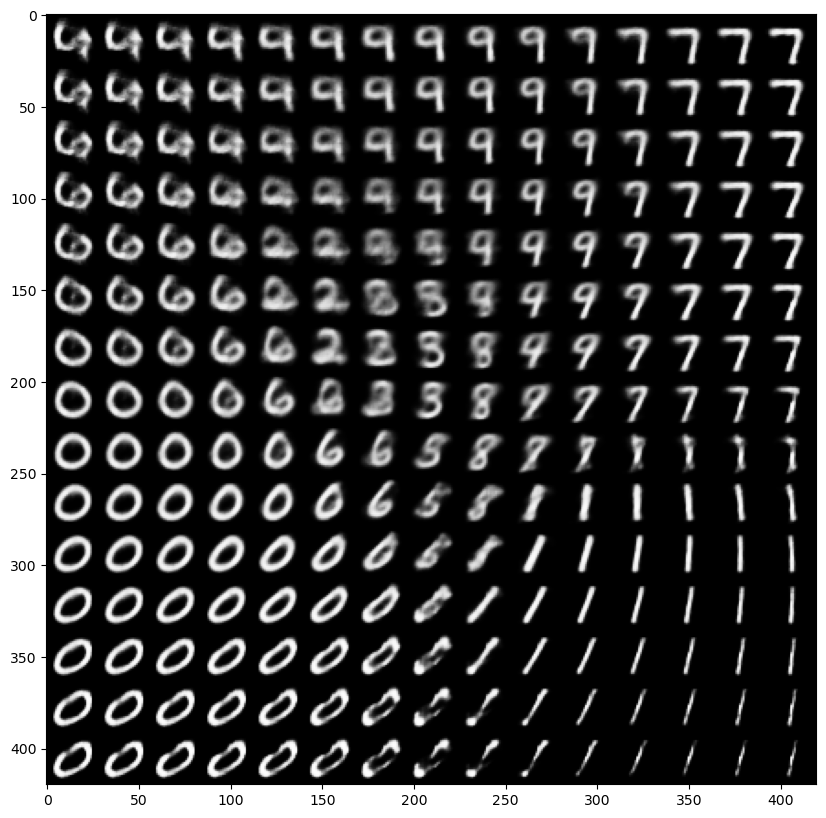

In [9]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt

# Define Encoder
latent_dim = 2
encoder_inputs = keras.Input(shape=(28, 28, 1))
x = layers.Conv2D(32, 3, activation="relu", strides=2, padding="same")(encoder_inputs)
x = layers.Conv2D(64, 3, activation="relu", strides=2, padding="same")(x)
x = layers.Flatten()(x)
z_mean = layers.Dense(latent_dim, name="z_mean")(x)
z_log_var = layers.Dense(latent_dim, name="z_log_var")(x)

# Sampling function
def sampling(z_mean, z_log_var):
    batch = tf.shape(z_mean)[0]
    dim = tf.shape(z_mean)[1]
    epsilon = tf.random.normal(shape=(batch, dim))
    return z_mean + tf.exp(0.5 * z_log_var) * epsilon

z = layers.Lambda(lambda args: sampling(*args), output_shape=(latent_dim,), name='z')([z_mean, z_log_var])
encoder = keras.Model(encoder_inputs, [z_mean, z_log_var, z], name="encoder")

# Define Decoder
latent_inputs = keras.Input(shape=(latent_dim,))
x = layers.Dense(7 * 7 * 64, activation="relu")(latent_inputs)
x = layers.Reshape((7, 7, 64))(x)
x = layers.Conv2DTranspose(64, 3, activation="relu", strides=2, padding="same")(x)
x = layers.Conv2DTranspose(32, 3, activation="relu", strides=2, padding="same")(x)
decoder_outputs = layers.Conv2DTranspose(1, 3, activation="sigmoid", padding="same")(x)
decoder = keras.Model(latent_inputs, decoder_outputs, name="decoder")

# VAE model
outputs = decoder(encoder(encoder_inputs)[2])
vae = keras.Model(encoder_inputs, outputs, name="vae")

# Loss function
reconstruction_loss = keras.losses.binary_crossentropy(encoder_inputs, outputs)
reconstruction_loss *= 28 * 28
kl_loss = 1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var)
kl_loss = tf.reduce_mean(kl_loss)
kl_loss *= -0.5
vae_loss = tf.reduce_mean(reconstruction_loss + kl_loss)

# Compile VAE model
vae.add_loss(vae_loss)
vae.compile(optimizer='adam')

# Load MNIST data
(x_train, _), (x_test, _) = keras.datasets.mnist.load_data()
x_train = x_train.astype('float32') / 255.
x_train = np.expand_dims(x_train, -1)

# Train the VAE
vae.fit(x_train, x_train, epochs=10, batch_size=128)

# Generate new images by varying latent variables
n = 15
digit_size = 28
figure = np.zeros((digit_size * n, digit_size * n))
grid_x = np.linspace(-3, 3, n)
grid_y = np.linspace(-3, 3, n)

for i, yi in enumerate(grid_x):
    for j, xi in enumerate(grid_y):
        z_sample = np.array([[xi, yi]])
        x_decoded = decoder.predict(z_sample)
        digit = x_decoded[0].reshape(digit_size, digit_size)
        figure[i * digit_size: (i + 1) * digit_size, j * digit_size: (j + 1) * digit_size] = digit

plt.figure(figsize=(10, 10))
plt.imshow(figure, cmap='Greys_r')
plt.show()
